- author: Macrina Lobo

In [1]:
library(ArchR)

#set threads to 1/2 of available cores (assuming each core has 2 threads)
addArchRThreads(threads = 8)

#set genome
addArchRGenome("mm10")

Loading required package: ggplot2

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    unio

In [2]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following object is masked from ‘package:matrixStats’:

    count


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# customized ArchR function
.ArchRHeatmap <- function(
  mat = NULL, 
  scale = FALSE,
  limits = c(min(mat), max(mat)),
  colData = NULL, 
  color = paletteContinuous(set = "solarExtra", n = 100),
  clusterCols = TRUE,
  clusterRows = FALSE,
  labelCols = FALSE,
  labelRows = FALSE,
  colorMap = NULL,
  useRaster = TRUE,
  rasterQuality = 5,
  split = NULL,
  fontSizeRows = 10,
  fontSizeCols = 10,
  fontSizeLabels = 8,
  colAnnoPerRow = 4,
  showRowDendrogram = FALSE,
  showColDendrogram = FALSE,
  customRowLabel = NULL,
  customRowLabelIDs = NULL,
  customColLabel = NULL,  
  customColLabelIDs = NULL,
  customLabelWidth = 0.75,
  rasterDevice = "png",
  padding = 45,
  borderColor = NA,
  draw = TRUE,
  name = "Heatmap"
  ){
  
  #Packages
  #.requirePackage("ComplexHeatmap", source = "bioc")
  #.requirePackage("circlize", source = "cran")
  
  #Z-score
  if (scale) {
    print("PROBLEM; scaling not supported yet")
    #message("Scaling Matrix..")
    #mat <- .rowZscores(mat, limit = FALSE)
    #name <- paste0(name," Z-Scores")
  }
  
  #Get A Color map if null
  if (is.null(colorMap)) {
    colorMap <- .colorMapAnno(colData)
  }
  
  #Prepare ColorMap format for Complex Heatmap
  if (!is.null(colData)){
    colData = data.frame(colData)
    colorMap <- .colorMapForCH(colorMap, colData) #change
    showLegend <- .checkShowLegend(colorMap[match(names(colorMap), colnames(colData))]) #change
  }else {
    colorMap <- NULL
    showLegend <- NULL
  }
  
  #Prepare Limits if needed
  breaks <- NULL
  if (!is.null(limits)) {
    mat[mat > max(limits)] <- max(limits)
    mat[mat < min(limits)] <- min(limits)
  }else{
    limits <- c(round(min(mat),2), round(max(mat),2))
  }

  #Scale Values 0 - 1
  mat <- (mat - min(limits)) / (max(limits) - min(limits))
  breaks <- seq(0, 1, length.out = length(color))
  color <- circlize::colorRamp2(breaks, color)

  if(exists('anno_mark', where='package:ComplexHeatmap', mode='function')){
    anno_check_version_rows <- ComplexHeatmap::anno_mark
    anno_check_version_cols <- ComplexHeatmap::anno_mark
  }else{
    anno_check_version_rows <- ComplexHeatmap::row_anno_link
    anno_check_version_cols <- ComplexHeatmap::column_anno_link
  }

  #Annotation Heatmap
  if(!is.null(colData) & !is.null(customColLabel)){
    message("Adding Annotations..")
    if(is.null(customColLabelIDs)){
      customColLabelIDs <- colnames(mat)[customColLabel]
    }
    ht1Anno <- HeatmapAnnotation(
      df = colData,
      col = colorMap, 
      show_legend = showLegend,
      show_annotation_name = TRUE,
      gp = gpar(col = "NA"),
      annotation_legend_param =
        list(
          nrow = min(colAnnoPerRow, max(round(nrow(colData)/colAnnoPerRow), 1))
        ),
      foo = anno_check_version_cols(at = customColLabel, labels = customColLabelIDs, labels_gp = gpar(fontsize = fontSizeLabels))
    )

  }else if(!is.null(colData)){
    message("Adding Annotations..")
    ht1Anno <- HeatmapAnnotation(
      df = colData,
      col = colorMap, 
      show_legend = showLegend,
      show_annotation_name = TRUE,
      gp = gpar(col = "NA"),
      annotation_legend_param =
        list(
          nrow = min(colAnnoPerRow, max(round(nrow(colData)/colAnnoPerRow), 1))
        )
    )
  }else if(is.null(colData) & !is.null(customColLabel)){
    if(is.null(customColLabelIDs)){
      customColLabelIDs <- colnames(mat)[customColLabel]
    }
    message("Adding Annotations..")
    #print(customColLabel)
    #print(customColLabelIDs)
    #ht1Anno <- columnAnnotation(foo = anno_check_version_cols(
    #   at = customColLabel, labels = customColLabelIDs),
    #   width = unit(customLabelWidth, "cm") + max_text_width(customColLabelIDs))
    #ht1Anno <- HeatmapAnnotation(foo = anno_mark(at = c(1:4, 20, 60, 1097:1100), labels = month.name[1:10]))
    ht1Anno <- HeatmapAnnotation(foo = anno_check_version_cols(at = customColLabel, labels = customColLabelIDs, labels_gp = gpar(fontsize = fontSizeLabels)))
  }else{
    ht1Anno <- NULL
  }

  message("Preparing Main Heatmap..")
  ht1 <- Heatmap(
    
    #Main Stuff
    matrix = as.matrix(mat),
    name = name,
    col = color, 
    
    #Heatmap Legend
    heatmap_legend_param = 
      list(
           at = c(0, 1),
           labels = c(round(min(limits),2), round(max(limits),2)),
           color_bar = "continuous", 
           legend_direction = "horizontal",
           legend_width = unit(3, "cm")
      ), 
    rect_gp = gpar(col = borderColor), 
    
    #Column Options
    show_column_names = labelCols,
    cluster_columns = clusterCols, 
    show_column_dend = showColDendrogram,
    clustering_method_columns = "ward.D2",
    column_names_gp = gpar(fontsize = fontSizeCols), 
    column_names_max_height = unit(100, "mm"),
    
    #Row Options
    show_row_names = labelRows,
    row_names_gp = gpar(fontsize = fontSizeRows), 
    cluster_rows = clusterRows, 
    show_row_dend = showRowDendrogram, 
    clustering_method_rows = "ward.D2",
    split = split, 
    
    #Annotation
    top_annotation = ht1Anno, 

    #Raster Info
    use_raster = useRaster, 
    raster_device = rasterDevice, 
    raster_quality = rasterQuality
  )

  if(!is.null(customRowLabel)){
    if(is.null(customRowLabelIDs)){
      customRowLabelIDs <- rownames(mat)[customRowLabel]
    }
    ht1 <- ht1 + rowAnnotation(link = 
        anno_check_version_rows(at = customRowLabel, labels = customRowLabelIDs, labels_gp = gpar(fontsize = fontSizeLabels)),
        width = unit(customLabelWidth, "cm") + max_text_width(customRowLabelIDs))
  }

  if(draw){
    draw(ht1, 
      padding = unit(c(padding, padding, padding, padding), "mm"), 
      heatmap_legend_side = "bot", 
      annotation_legend_side = "bot")
  }else{
    ht1
  }

}


.colorMapForCH <- function(colorMap = NULL, colData = NULL){
  colorMap <- colorMap[which(names(colorMap) %in% colnames(colData))]
  colorMapCH <- lapply(seq_along(colorMap), function(x){
    if(attr(colorMap[[x]],"discrete")){
      colorx <- colorMap[[x]]
    }else{
      vals <- colData[[names(colorMap)[x]]][!is.na(colData[[names(colorMap)[x]]])]
      s <-  seq(min(vals), max(vals), length.out = length(colorMap[[x]]))
      colorx <- circlize::colorRamp2(s, colorMap[[x]])
    }
    if(any(is.na(names(colorx)))){
      names(colorx)[is.na(names(colorx))] <- paste0("NA",seq_along(names(colorx)[is.na(names(colorx))]))
    }
    return(colorx)
  })
  names(colorMapCH) <- names(colorMap)
  return(colorMapCH)
}

.checkShowLegend <- function(colorMap = NULL, max_discrete = 30){
  show <- lapply(seq_along(colorMap), function(x){
      if(attr(colorMap[[x]],"discrete") && length(unique(colorMap[[x]])) > max_discrete){
        sl <- FALSE
      }else{
        sl <- TRUE
      }
      return(sl)
    }) %>% unlist
  names(show) <- names(colorMap)
  return(show)
}

.colorMapAnno <- function(colData = NULL, customAnno = NULL, discreteSet = "stallion", continuousSet = "solarExtra"){
  discreteCols <- sapply(colData,function(x) !is.numeric(x))
  if(!is.null(customAnno)){
    colorMap <- lapply(seq_along(discreteCols),function(x){
      if(discreteCols[x]){
        colors <- paletteDiscrete(values = colData[[names(discreteCols[x])]], set = discreteSet)
        names(colors) <- unique(colData[[names(discreteCols[x])]])
        attr(colors, "discrete") <- TRUE
      }else{
        colors <- paletteContinuous(set = continuousSet)
        attr(colors, "discrete") <- FALSE
      }
      if(length(which(customAnno[,1] %in% names(discreteCols[x]))) > 0){
        if(length(which(customAnno[,2] %in% names(colors))) > 0){
          customAnnox <- customAnno[which(customAnno[,2] %in% names(colors)),]
          colors[which(names(colors) %in% customAnnox[,2])] <- paste0(customAnnox[match(names(colors),customAnnox[,2]),3])
        }
      }
      return(colors)
    })
    names(colorMap) <- colnames(colData)
    return(colorMap)
  }else{
    colorMap <- lapply(seq_along(discreteCols), function(x){
      if(discreteCols[x]){
       colors <- paletteDiscrete(values = colData[[names(discreteCols[x])]], set = discreteSet)
       names(colors) <- unique(colData[[names(discreteCols[x])]])
       attr(colors, "discrete") <- TRUE
      }else{
       colors <- paletteContinuous(set = continuousSet)
       attr(colors, "discrete") <- FALSE
      }
      return(colors)
    })
    names(colorMap) <- colnames(colData)
    return(colorMap)
  }

}

.binarySort <- function(m = NULL, scale = FALSE, cutOff = 1, lmat = NULL, clusterCols = TRUE){

  if(is.null(lmat)){
    #Compute Row-Zscores
    if(scale){
      lmat <- sweep(m - rowMeans(m), 1, matrixStats::rowSds(m), `/`)
    }else{
      lmat <- m
    }
    lmat <- lmat >= cutOff
  }

  #Transpose
  m <- t(m)
  lmat <- t(lmat)

  #Identify Column Ordering
  if(clusterCols){
    hc <- hclust(dist(m))
    colIdx <- hc$order
    m <- t(m[colIdx,])
    lmat <- t(lmat[colIdx,])
  }else{
    m <- t(m)
    lmat <- t(lmat)
    hc <- NULL
  }

  #Identify Row Ordering
  rowIdx <- do.call("order", c(as.data.frame(lmat)[seq_len(ncol(lmat))], list(decreasing = TRUE)))
  m <- t(m[rowIdx,])
  lmat <- t(lmat[rowIdx,])

  #Transpose
  m <- t(m)
  lmat <- t(lmat)

  return(list(mat = m, hclust = hc))

}




In [4]:
setwd("/Users/LoboM/Documents/e11_12_analysis/")

In [5]:
projFoxn1ko = loadArchRProject( "E11_E12_cisbp2_deviations")

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

In [6]:
projFoxn1ko


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /Users/LoboM/Documents/e11_12_analysis/E11_E12_cisbp2_deviations 
samples(4): e11_5rep1 e12_5rep2 e12_5rep1 e11_5rep2
sampleColData names(1): ArrowFiles
cellColData names(46): Sample TSSEnrichment ...
  predictedGroup_e11_12_fil_clean predictedScore_e11_12_fil_clean
numberOfCells(1): 10890
medianTSS(1): 15.851
medianFrags(1): 24133

In [7]:
getPeakSet(projFoxn1ko)

GRanges object with 270210 ranges and 13 metadata columns:
      seqnames              ranges strand |     score replicateScoreQuantile
         <Rle>           <IRanges>  <Rle> | <numeric>              <numeric>
   C7     chr1     3094538-3095038      * |   29.2276                  0.756
  C18     chr1     3117258-3117758      * |   7.33069                  0.359
   C3     chr1     3191138-3191638      * |   2.81117                  0.046
   C3     chr1     3191655-3192155      * |   24.5252                   0.62
  C14     chr1     3221076-3221576      * |   5.25034                  0.637
  ...      ...                 ...    ... .       ...                    ...
   C4     chrX 169933032-169933532      * |   4.86344                  0.254
  C11     chrX 169933569-169934069      * |   28.3657                  0.756
   C4     chrX 169937107-169937607      * |   8.83136                  0.343
  C12     chrX 169940527-169941027      * |   35.9207                  0.793
   C4     chrX 16

In [8]:
getMatrixFromProject(projFoxn1ko)

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-60205c13975e-Date-2021-07-14_Time-11-09-11.log
If there is an issue, please report to github with logFile!

2021-07-14 11:09:36 : Organizing colData, 0.428 mins elapsed.

2021-07-14 11:09:36 : Organizing rowData, 0.429 mins elapsed.

2021-07-14 11:09:36 : Organizing rowRanges, 0.429 mins elapsed.

2021-07-14 11:09:36 : Organizing Assays (1 of 1), 0.429 mins elapsed.

2021-07-14 11:09:42 : Constructing SummarizedExperiment, 0.524 mins elapsed.

2021-07-14 11:09:42 : Finished Matrix Creation, 0.531 mins elapsed.



class: SummarizedExperiment 
dim: 24333 10890 
metadata(0):
assays(1): GeneScoreMatrix
rownames: NULL
rowData names(6): seqnames start ... name idx
colnames(10890): e11_5rep1#GTGGATTAGCTAACAA-1
  e11_5rep1#TTACTCACAGATAAGT-1 ... e11_5rep2#GCGCCAATCGCACCTT-1
  e11_5rep2#GGGAACACACTCCTCA-1
colData names(46): BlacklistRatio DoubletEnrichment ...
  predictedGroup_e11_12_fil_clean predictedScore_e11_12_fil_clean

In [9]:
markersPeaks <- getMarkerFeatures(
    ArchRProj = projFoxn1ko, 
    useMatrix = "PeakMatrix", 
    groupBy = "Clusters_test_1.4_nFrags",
  bias = c("TSSEnrichment", "log10(nFrags)"),
  testMethod = "wilcoxon"
)

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-602031a349db-Date-2021-07-14_Time-11-09-42.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Integer.Matrix

2021-07-14 11:09:43 : Matching Known Biases, 0.006 mins elapsed.

###########
2021-07-14 11:11:26 : Completed Pairwise Tests, 1.731 mins elapsed.
###########

ArchR logging successful to : ArchRLogs/ArchR-getMarkerFeatures-602031a349db-Date-2021-07-14_Time-11-09-42.log



- subset to distal peaks and plot heatmap
- subset to proximal peaks and plot heatmap
- plot differential variability 

In [10]:
markersPeaks

class: SummarizedExperiment 
dim: 270210 22 
metadata(2): MatchInfo Params
assays(7): Log2FC Mean ... AUC MeanBGD
rownames(270210): 1 2 ... 270209 270210
rowData names(4): seqnames idx start end
colnames(22): C1 C2 ... C21 C22
colData names(0):

In [11]:
tmp_peaks = data.frame(projFoxn1ko@peakSet)

In [10]:
tmp_peaks

seqnames,start,end,width,strand,score,replicateScoreQuantile,groupScoreQuantile,Reproducibility,GroupReplicate,distToGeneStart,nearestGene,peakType,distToTSS,nearestTSS,GC,idx,N
<fct>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<int>,<dbl>
chr1,3094538,3095038,501,*,29.22760,0.756,0.644,2,C7._.e12_5rep2,576709,Xkr4,Distal,120843,uc007afg.1,0.4112,1,0
chr1,3117258,3117758,501,*,7.33069,0.359,0.173,2,C18._.e12_5rep1,553989,Xkr4,Distal,98123,uc007afg.1,0.3912,2,0
chr1,3191138,3191638,501,*,2.81117,0.046,0.004,2,C3._.e11_5rep1,480109,Xkr4,Distal,24243,uc007afg.1,0.4331,3,0
chr1,3191655,3192155,501,*,24.52520,0.620,0.444,2,C3._.e11_5rep1,479592,Xkr4,Distal,23726,uc007afg.1,0.4311,4,0
chr1,3221076,3221576,501,*,5.25034,0.637,0.370,3,C14._.e11_5rep1,450171,Xkr4,Intronic,5693,uc007afg.1,0.4232,5,0
chr1,3268250,3268750,501,*,31.93780,0.765,0.657,2,C4._.e11_5rep2,402997,Xkr4,Intronic,52867,uc007afg.1,0.3792,6,0
chr1,3360826,3361326,501,*,5.70397,0.652,0.277,2,C20._.e12_5rep2,310421,Xkr4,Intronic,145443,uc007afg.1,0.4212,7,0
chr1,3395754,3396254,501,*,14.63650,0.749,0.540,2,C8._.e12_5rep2,275493,Xkr4,Intronic,180371,uc007afg.1,0.3593,8,0
chr1,3398459,3398959,501,*,3.05460,0.252,0.061,2,C15._.e12_5rep2,272788,Xkr4,Intronic,183076,uc007afg.1,0.3812,9,0


In [12]:
tmp_peaks = data.frame(projFoxn1ko@peakSet)
tmp_diff_peaks = data.frame(rowData(markersPeaks))

In [13]:
diff_peaks_join_peakset = left_join(tmp_diff_peaks, tmp_peaks, 
              by = c("seqnames" = "seqnames", "start" = "start", "end" = "end"))

In [14]:
diff_peaks_join_peakset$name = paste(diff_peaks_join_peakset$nearestGene, diff_peaks_join_peakset$distToTSS,sep="_")

In [15]:
diff_peaks_join_peakset$unique_id = paste(diff_peaks_join_peakset$seqnames, diff_peaks_join_peakset$start, diff_peaks_join_peakset$end, sep=":")

In [16]:
rowData(markersPeaks) = diff_peaks_join_peakset

In [16]:
# TEST
tmpnew = data.frame(rowData(markersPeaks))
tmpnew[tmpnew$nearestGene=='Foxn1',]

,seqnames,idx.x,start,end,width,strand,score,replicateScoreQuantile,groupScoreQuantile,Reproducibility,⋯,distToGeneStart,nearestGene,peakType,distToTSS,nearestTSS,GC,idx.y,N,name,unique_id
,<chr>,<int>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>
41735,chr11,9128,78368134,78368634,501,*,3.57925,0.530,0.303,3,⋯,18223,Foxn1,Intronic,18223,uc009clv.4,0.5409,9128,0,Foxn1_18223,chr11:78368134:78368634
41736,chr11,9129,78370324,78370824,501,*,84.52220,0.842,0.767,2,⋯,16033,Foxn1,Intronic,16033,uc009clv.4,0.5389,9129,0,Foxn1_16033,chr11:78370324:78370824
41737,chr11,9130,78372157,78372657,501,*,4.37028,0.190,0.033,2,⋯,14200,Foxn1,Intronic,14200,uc009clv.4,0.5150,9130,0,Foxn1_14200,chr11:78372157:78372657
41738,chr11,9131,78372661,78373161,501,*,24.01340,0.679,0.549,2,⋯,13696,Foxn1,Intronic,13696,uc009clv.4,0.5309,9131,0,Foxn1_13696,chr11:78372661:78373161
41739,chr11,9132,78373639,78374139,501,*,4.37664,0.255,0.105,2,⋯,12718,Foxn1,Intronic,12718,uc009clv.4,0.4870,9132,0,Foxn1_12718,chr11:78373639:78374139
41740,chr11,9133,78374267,78374767,501,*,197.38600,0.991,0.985,3,⋯,12090,Foxn1,Intronic,12090,uc009clv.4,0.5269,9133,0,Foxn1_12090,chr11:78374267:78374767
41741,chr11,9134,78374871,78375371,501,*,109.96700,0.934,0.893,2,⋯,11486,Foxn1,Intronic,11486,uc009clv.4,0.5230,9134,0,Foxn1_11486,chr11:78374871:78375371
41742,chr11,9135,78377244,78377744,501,*,5.01256,0.245,0.068,2,⋯,9113,Foxn1,Intronic,9113,uc009clv.4,0.5289,9135,0,Foxn1_9113,chr11:78377244:78377744
41743,chr11,9136,78377747,78378247,501,*,55.13600,0.890,0.826,2,⋯,8610,Foxn1,Intronic,8610,uc009clv.4,0.5888,9136,0,Foxn1_8610,chr11:78377747:78378247


In [17]:
handpicked_genes  <- read.csv("~/Dropbox/pharynx_celloracle/objects/e11_e12_dataframes/genes_to_label.csv", stringsAsFactors = F, header = F)[[1]]
add_name = function(X, c) {
  if(nrow(X)==0) return(NULL)
  X$cluster = c
  X
}

In [18]:
handpicked_genes[89]='Grhl1'

In [19]:
markers_label_handpicked = diff_peaks_join_peakset[as.vector(diff_peaks_join_peakset$nearestGene %in% handpicked_genes),]$name

In [20]:
assays(markersPeaks)

List of length 7
names(7): Log2FC Mean FDR Pval MeanDiff AUC MeanBGD

In [21]:
rowData(markersPeaks)

DataFrame with 270210 rows and 21 columns
          seqnames     idx.x     start       end     width   strand     score
       <character> <integer> <integer> <integer> <integer> <factor> <numeric>
1             chr1         1   3094538   3095038       501        *   29.2276
2             chr1         2   3117258   3117758       501        *   7.33069
3             chr1         3   3191138   3191638       501        *   2.81117
4             chr1         4   3191655   3192155       501        *   24.5252
5             chr1         5   3221076   3221576       501        *   5.25034
...            ...       ...       ...       ...       ...      ...       ...
270206        chrX      4721 169933032 169933532       501        *   4.86344
270207        chrX      4722 169933569 169934069       501        *   28.3657
270208        chrX      4723 169937107 169937607       501        *   8.83136
270209        chrX      4724 169940527 169941027       501        *   35.9207
270210        chrX    

In [22]:
markersPeaks

class: SummarizedExperiment 
dim: 270210 22 
metadata(2): MatchInfo Params
assays(7): Log2FC Mean ... AUC MeanBGD
rownames(270210): 1 2 ... 270209 270210
rowData names(21): seqnames idx.x ... name unique_id
colnames(22): C1 C2 ... C21 C22
colData names(0):

In [23]:
subset(markersPeaks,rowData(markersPeaks)$peakType == "Distal")

class: SummarizedExperiment 
dim: 104325 22 
metadata(2): MatchInfo Params
assays(7): Log2FC Mean ... AUC MeanBGD
rownames(104325): 1 2 ... 270169 270170
rowData names(21): seqnames idx.x ... name unique_id
colnames(22): C1 C2 ... C21 C22
colData names(0):

In [22]:
markersPeaks_promoter <- subset(markersPeaks, rowData(markersPeaks)$peakType == "Promoter") # subset only to the patients with available subtype information

In [17]:
markersPeaks_distal <- subset(markersPeaks, rowData(markersPeaks)$peakType == "Distal") # subset only to the patients with available subtype information

In [18]:
dim(markersPeaks_distal)

[1] 104325     22

In [25]:
dim(markersPeaks_promoter)

[1] 25250    22

In [26]:
unique(rowData(markersPeaks_distal)$peakType)

[1] "Distal"

In [27]:
unique(rowData(markersPeaks_promoter)$peakType)

[1] "Promoter"

In [20]:
marker_tables_distal = markersPeaks_distal %>% getMarkers(cutOff = "FDR <= 0.1 & Log2FC >= 0.5")

In [29]:
marker_tables_promoter = markersPeaks_promoter %>% getMarkers(cutOff = "FDR <= 0.1 & Log2FC >= 0.5")

In [88]:


marker_tables_promoter_tmp = marker_tables_promoter %>%  as.data.frame() 
# %>%
  #dplyr::mutate( highest_logfc_by_gene = ave(Log2FC, name, FUN = max)) %>%
  #dplyr::mutate( is_highest = Log2FC == highest_logfc_by_gene) %>%
  #subset(is_highest) %>%
  # dplyr::group_by(cluster) %>%
  # dplyr::mutate(rank = rank(-Log2FC, ties = "first")) %>%
  # dplyr::top_n(Log2FC, n = 1000000) %>%
  # dplyr::arrange(mixedrank(cluster), desc(Log2FC))


write.csv(marker_tables_promoter_tmp,"all_differentially_expressed_peaks_promoter.csv", row.names = FALSE)




In [23]:
length(unique(marker_tables_distal_tmp$unique_id))

[1] 55840

In [89]:
marker_tables_distal_tmp = marker_tables_distal %>%  as.data.frame() 
# %>%
  #dplyr::mutate( highest_logfc_by_gene = ave(Log2FC, name, FUN = max)) %>%
  #dplyr::mutate( is_highest = Log2FC == highest_logfc_by_gene) %>%
  #subset(is_highest) %>%
  # dplyr::group_by(cluster) %>%
  # dplyr::mutate(rank = rank(-Log2FC, ties = "first")) %>%
  # dplyr::top_n(Log2FC, n = 1000000) %>%
  # dplyr::arrange(mixedrank(cluster), desc(Log2FC))


write.csv(marker_tables_distal_tmp,"all_differentially_expressed_peaks_distal.csv", row.names = FALSE)




In [44]:
marker_tables = markersPeaks %>% getMarkers(cutOff = "FDR <= 0.1 & Log2FC >= 0.5")

marker_tables_S = mapply(add_name, marker_tables, names(marker_tables), SIMPLIFY = F) %>% Reduce(f = rbind)
mixedrank = function(x) order(gtools::mixedorder(x))


markers_top_S = marker_tables_S %>%  
  as.data.frame() %>%
  #dplyr::mutate( highest_logfc_by_gene = ave(Log2FC, name, FUN = max)) %>%
  #dplyr::mutate( is_highest = Log2FC == highest_logfc_by_gene) %>%
  #subset(is_highest) %>%
  dplyr::group_by(cluster) %>%
  dplyr::mutate(rank = rank(-Log2FC, ties = "first")) %>%
  # dplyr::top_n(Log2FC, n = 1000000) %>%
  dplyr::arrange(mixedrank(cluster), desc(Log2FC))


write.csv(markers_top_S,"all_differentially_expressed_peaks.csv", row.names = FALSE)



In [45]:
write.csv(metadata(projFoxn1ko@peakSet)$PeakCallSummary,"all_peaks_summary.csv")

- DISTAL

In [30]:
# marker_tables = markersPeaks %>% getMarkers(cutOff = "FDR <= 0.01 & Log2FC >= 0.5")
marker_tables_distal = markersPeaks_distal %>% getMarkers(cutOff = "FDR <= 0.01 & Log2FC >= 0.5")
marker_tables_distal = marker_tables_distal
marker_tables_distal = mapply(add_name, marker_tables_distal, names(marker_tables_distal), SIMPLIFY = F) %>% Reduce(f = rbind)
mixedrank = function(x) order(gtools::mixedorder(x))


markers_top_distal = marker_tables_distal %>%  
  as.data.frame() %>%
  dplyr::mutate( highest_logfc_by_gene = ave(Log2FC, name, FUN = max)) %>%
  dplyr::mutate( is_highest = Log2FC == highest_logfc_by_gene) %>%
  subset(is_highest) %>%
  dplyr::group_by(cluster) %>%
  dplyr::mutate(rank = rank(-Log2FC, ties = "first")) %>%
 #  dplyr::top_n(Log2FC, n = 100) %>%
  dplyr::arrange(mixedrank(cluster), desc(Log2FC))

In [31]:
# marker_tables = markersPeaks %>% getMarkers(cutOff = "FDR <= 0.01 & Log2FC >= 0.5")
marker_tables_promoter = markersPeaks_promoter %>% getMarkers(cutOff = "FDR <= 0.01 & Log2FC >= 0.5")
marker_tables_promoter = marker_tables_promoter
marker_tables_promoter = mapply(add_name, marker_tables_promoter, names(marker_tables_promoter), SIMPLIFY = F) %>% Reduce(f = rbind)
mixedrank = function(x) order(gtools::mixedorder(x))


markers_top_promoter = marker_tables_promoter %>%  
  as.data.frame() %>%
  dplyr::mutate( highest_logfc_by_gene = ave(Log2FC, name, FUN = max)) %>%
  dplyr::mutate( is_highest = Log2FC == highest_logfc_by_gene) %>%
  subset(is_highest) %>%
  dplyr::group_by(cluster) %>%
  dplyr::mutate(rank = rank(-Log2FC, ties = "first")) %>%
 #  dplyr::top_n(Log2FC, n = 100) %>%
  dplyr::arrange(mixedrank(cluster), desc(Log2FC))

In [32]:
dim(marker_tables_distal)

[1] 35182    25

In [53]:


install.packages(c("viridisLite"), dry_run=T)


The downloaded binary packages are in
	/var/folders/hm/9slqvx2n1_q0y184ts0ck7sc0000gp/T//RtmpjvHWt6/downloaded_packages


In [54]:
install.packages("viridisLite")


The downloaded binary packages are in
	/var/folders/hm/9slqvx2n1_q0y184ts0ck7sc0000gp/T//RtmpjvHWt6/downloaded_packages


In [57]:
install.packages('viridis')


The downloaded binary packages are in
	/var/folders/hm/9slqvx2n1_q0y184ts0ck7sc0000gp/T//RtmpjvHWt6/downloaded_packages


In [55]:
library(viridisLite)

In [59]:
# markers_top








markers_label   = markers_top_distal %>% subset(rank<=2,  select = "name", drop = T) 
markers_include = markers_top_distal %>% subset(rank<=4000000, select = "unique_id", drop = T) 

length(markers_include)
marker_subset = markersPeaks_distal[rowData(markersPeaks_distal)$unique_id %in% markers_include,]
dim(marker_subset)

labelMarkers = markers_label_handpicked %>% union(markers_label)

length(labelMarkers)


heatmapGS <- plotMarkerHeatmap(
  seMarker = marker_subset, cutOff = "FDR <= 0.01 & Log2FC >= 0.5",
  # cutOff = "FDR==FDR", #TRUE i.e. use all genes
# labelRows = FALSE,
  labelMarkers = labelMarkers,
  #transpose = TRUE,
  #clusterCols=F,
  # binaryClusterRows = F
  pal = viridisLite::mako(256)
)








[1] 27295

[1] 27295    22

[1] 2674

ArchR logging to : ArchRLogs/ArchR-plotMarkerHeatmap-131f34c4f714f-Date-2021-07-09_Time-13-47-04.log
If there is an issue, please report to github with logFile!

Identified 27295 markers!



   [1] "Tfap2b_37432"         "Tfap2b_29701"         "Tfap2b_16251"        
   [4] "Tfap2b_3043"          "Tfap2b_2534"          "Tfap2b_1130"         
   [7] "Tfap2b_226"           "Tfap2b_1066"          "Tfap2b_1377"         
  [10] "Tfap2b_784"           "Tfap2b_65"            "Tfap2b_772"          
  [13] "Tfap2b_422"           "Tfap2b_4703"          "Tfap2b_9018"         
  [16] "Tfap2b_12237"         "Tfap2b_13054"         "Tfap2b_17003"        
  [19] "Tfap2b_17852"         "Tfap2b_20001"         "Tfap2b_21036"        
  [22] "Tfap2b_21643"         "Tfap2b_22287"         "Tfap2b_22902"        
  [25] "Tfap2b_26347"         "Tfap2b_27598"         "Tfap2b_33264"        
  [28] "Tfap2b_33223"         "Tfap2b_70048"         "Tfap2b_70647"        
  [31] "Tfap2b_97807"         "Tfap2b_131269"        "Tfap2b_134227"       
  [34] "Tfap2b_174461"        "Tfap2b_175465"        "Tfap2b_188697"       
  [37] "Tfap2b_192471"        "Tfap2b_221640"        "Tfap2b_223074"       
  [40] "Tfap

Preparing Main Heatmap..

ArchR logging successful to : ArchRLogs/ArchR-plotMarkerHeatmap-131f34c4f714f-Date-2021-07-09_Time-13-47-04.log



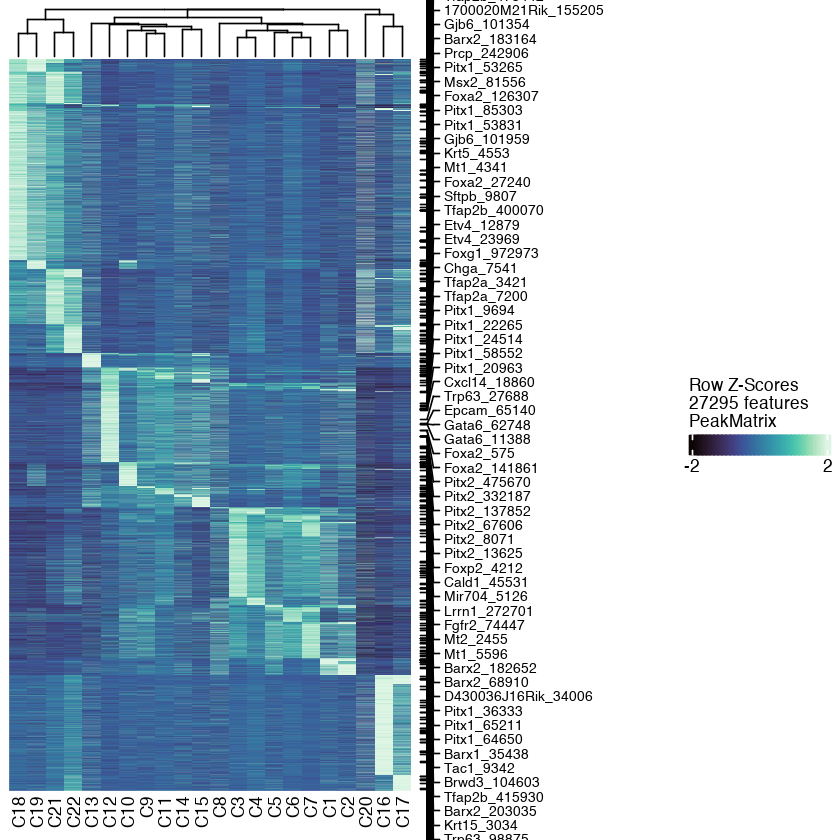

In [60]:
heatmapGS

In [ ]:
# markers_top








markers_label   = markers_top_distal %>% subset(rank<=2,  select = "name", drop = T) 
markers_include = markers_top_distal %>% subset(rank<=4000000, select = "unique_id", drop = T) 

length(markers_include)
marker_subset = markersPeaks_distal[rowData(markersPeaks_distal)$unique_id %in% markers_include,]
dim(marker_subset)

labelMarkers = markers_label_handpicked %>% union(markers_label)

length(labelMarkers)


heatmapGS_distal <- plotMarkerHeatmap(
  seMarker = marker_subset, cutOff = "FDR <= 0.01 & Log2FC >= 0.5",
  # cutOff = "FDR==FDR", #TRUE i.e. use all genes
# labelRows = FALSE,
  labelMarkers = labelMarkers,return_matrix=TRUE,
  #transpose = TRUE,
  #clusterCols=F,
  # binaryClusterRows = F
  pal = viridisLite::mako(256)
)









In [61]:
plotPDF(heatmapGS, name = "Fig3a_differentially_accessible_distal_peaks_logfc_0.5_pval_0.01.pdf", width = 8, height =50, addDOC = F, ArchRProj = projFoxn1ko)

Plotting ComplexHeatmap!



- PROMOTER

In [62]:
# marker_tables = markersPeaks %>% getMarkers(cutOff = "FDR <= 0.01 & Log2FC >= 0.5")
marker_tables_promoter = markersPeaks_promoter %>% getMarkers(cutOff = "FDR <= 0.01 & Log2FC >= 0.5")
marker_tables = marker_tables_promoter
marker_tables = mapply(add_name, marker_tables, names(marker_tables), SIMPLIFY = F) %>% Reduce(f = rbind)
mixedrank = function(x) order(gtools::mixedorder(x))


markers_top = marker_tables %>%  
  as.data.frame() %>%
  dplyr::mutate( highest_logfc_by_gene = ave(Log2FC, name, FUN = max)) %>%
  dplyr::mutate( is_highest = Log2FC == highest_logfc_by_gene) %>%
  subset(is_highest) %>%
  dplyr::group_by(cluster) %>%
  dplyr::mutate(rank = rank(-Log2FC, ties = "first")) %>%
 #  dplyr::top_n(Log2FC, n = 100) %>%
  dplyr::arrange(mixedrank(cluster), desc(Log2FC))

In [79]:
markers_top

seqnames,idx.x,start,end,width,strand,score,replicateScoreQuantile,groupScoreQuantile,Reproducibility,⋯,N,name,unique_id,Log2FC,FDR,MeanDiff,cluster,highest_logfc_by_gene,is_highest,rank
<chr>,<int>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<lgl>,<int>
chr4,15900,149128136,149128636,501,*,65.8577,0.934,0.873,2,⋯,0,Cort_1622,chr4:149128136:149128636,3.015315,1.027846e-05,0.21286940,C1,3.015315,TRUE,5
chr4,8593,106559570,106560070,501,*,79.4707,0.958,0.916,2,⋯,0,Dhcr24_1217,chr4:106559570:106560070,2.813333,4.231841e-05,0.27437909,C1,2.813333,TRUE,9
chr13,107,4233427,4233927,501,*,47.2132,0.888,0.793,2,⋯,0,Akr1c19_62,chr13:4233427:4233927,3.292033,1.463634e-03,0.10857923,C1,3.292033,TRUE,2
chr4,16874,152292271,152292771,501,*,69.7041,0.942,0.887,2,⋯,0,Hes3_858,chr4:152292271:152292771,2.190766,1.495674e-03,0.20359554,C1,2.190766,TRUE,13
chr4,5117,63172175,63172675,501,*,47.2132,0.888,0.793,2,⋯,0,Kif12_293,chr4:63172175:63172675,3.012762,1.724651e-03,0.12199435,C1,3.012762,TRUE,6
chr8,1989,22707260,22707760,501,*,40.0774,0.863,0.751,2,⋯,0,Ikbkb_926,chr8:22707260:22707760,2.376520,3.984679e-03,0.17094431,C1,2.376520,TRUE,11
chr10,5442,61089095,61089595,501,*,50.8569,0.899,0.809,2,⋯,0,Pcbd1_13,chr10:61089095:61089595,2.142612,4.290016e-03,0.15339770,C1,2.142612,TRUE,14
chr19,5020,43986358,43986858,501,*,73.5858,0.948,0.897,2,⋯,0,Cpn1_87,chr19:43986358:43986858,2.432526,4.502973e-03,0.15994553,C1,2.432526,TRUE,10
chr7,7619,81708125,81708625,501,*,47.2132,0.888,0.793,2,⋯,0,Homer2_847,chr7:81708125:81708625,2.983906,5.158255e-03,0.19310053,C1,2.983906,TRUE,7


In [68]:
# markers_top








markers_label   = markers_top_promoter %>% subset(rank<=2,  select = "name", drop = T) 
markers_include = markers_top_promoter %>% subset(rank<=4000000, select = "unique_id", drop = T) 

length(markers_include)
marker_subset = markersPeaks_promoter[rowData(markersPeaks_promoter)$unique_id %in% markers_include,]
dim(marker_subset)

labelMarkers = markers_label_handpicked %>% union(markers_label)

length(labelMarkers)


heatmapGS_promoter <- plotMarkerHeatmap(
  seMarker = marker_subset, cutOff = "FDR <= 0.01 & Log2FC >= 0.5",
  # cutOff = "FDR==FDR", #TRUE i.e. use all genes
# labelRows = FALSE,
  labelMarkers = labelMarkers,returnMatrix = TRUE,
  #transpose = TRUE,
  #clusterCols=F,
  # binaryClusterRows = F
  pal = viridisLite::mako(256),
)









[1] 2436

[1] 2436   22

[1] 2674

ArchR logging to : ArchRLogs/ArchR-plotMarkerHeatmap-131f325289f7a-Date-2021-07-09_Time-13-49-43.log
If there is an issue, please report to github with logFile!

Identified 2436 markers!



   [1] "Tfap2b_37432"       "Tfap2b_29701"       "Tfap2b_16251"      
   [4] "Tfap2b_3043"        "Tfap2b_2534"        "Tfap2b_1130"       
   [7] "Tfap2b_226"         "Tfap2b_1066"        "Tfap2b_1377"       
  [10] "Tfap2b_784"         "Tfap2b_65"          "Tfap2b_772"        
  [13] "Tfap2b_422"         "Tfap2b_4703"        "Tfap2b_9018"       
  [16] "Tfap2b_12237"       "Tfap2b_13054"       "Tfap2b_17003"      
  [19] "Tfap2b_17852"       "Tfap2b_20001"       "Tfap2b_21036"      
  [22] "Tfap2b_21643"       "Tfap2b_22287"       "Tfap2b_22902"      
  [25] "Tfap2b_26347"       "Tfap2b_27598"       "Tfap2b_33264"      
  [28] "Tfap2b_33223"       "Tfap2b_70048"       "Tfap2b_70647"      
  [31] "Tfap2b_97807"       "Tfap2b_131269"      "Tfap2b_134227"     
  [34] "Tfap2b_174461"      "Tfap2b_175465"      "Tfap2b_188697"     
  [37] "Tfap2b_192471"      "Tfap2b_221640"      "Tfap2b_223074"     
  [40] "Tfap2b_230888"      "Tfap2b_277582"      "Tfap2b_295754"     
  [43] "Tfap2b_29908

ArchR logging successful to : ArchRLogs/ArchR-plotMarkerHeatmap-131f325289f7a-Date-2021-07-09_Time-13-49-43.log



In [70]:
col.order <- c("C18","C19","C21","C22","C13","C12","C10","C9","C11","C14","C15","C8","C3","C4","C5","C6","C7","C1","C2","C20","C16","C17")


In [71]:
length(labelMarkers)

[1] 2674

In [83]:
mat

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,⋯,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22
Gm13582_76851,0.15435907,0.200592194,0.9940505,1.0822412,0.9900052,1.243074671,0.928560463,0.6197632,1.19000583,1.0376898700,⋯,-1.336316093,-0.65051816,-0.35710834,-1.4212396,-0.9827392,-1.05952456,-1.19338936,-1.1587734,-1.27076137,-0.5825217
9330117O12Rik_51282,-0.81397525,-1.038454561,1.2501846,1.5660309,1.0123242,1.380711484,1.351251625,0.6205279,0.67408099,1.0534172720,⋯,-0.609710467,-0.67796309,-0.61818193,-1.0127733,-0.7535749,-0.91630975,-0.95142989,-1.1654604,-0.80976773,-0.8814702
En2_45011,-0.28149514,0.104191069,1.3998611,1.8634094,0.9658557,1.692883931,1.366487357,-0.6345225,0.39149808,-0.3766077160,⋯,-1.173379705,-0.02561155,-0.21174251,0.1481721,-1.0529543,-0.52905357,-0.73535582,-1.3327118,-0.95614774,-1.0369845
Hoxb1_38269,0.99175344,1.241213883,1.2816882,1.4230294,1.1566476,1.034537005,1.205683353,0.0797175,-0.27566974,0.8504547357,⋯,-0.738077075,-0.86806454,-1.07177808,-0.4595406,-0.2548298,-0.81440475,-0.82043654,-2.0000000,-0.76211862,-0.2299301
Mettl15_385847,-0.16972771,-0.572228314,2.0000000,2.0000000,1.6532633,0.023635474,1.645515245,1.0128619,-0.37373139,-0.6952776788,⋯,-0.249413193,-0.63895198,-0.81261900,-0.7598324,-0.8126190,-0.56158102,-0.81261900,-0.8126190,-0.54259378,-0.5757134
Tle3_32929,1.40068935,0.082844034,1.4373582,1.2769257,0.6759279,0.316211520,0.960047022,1.4560523,-0.70321768,1.2801206885,⋯,-0.859188014,-0.56610833,-0.83674955,-0.1896831,-0.1214727,-1.11849775,-1.81937378,-1.0810311,-1.33112517,-0.1456397
Mycn_129568,2.00000000,1.243275681,1.1903763,1.2037307,1.3715717,0.165041947,0.714598452,0.4246705,-0.02656827,-0.0002339817,⋯,-0.637352839,-0.34750878,-1.84786408,-0.1056850,-0.2751020,-0.85476314,-1.61267775,-0.4829405,-1.12105442,-0.3564921
Efnb2_76563,0.42840578,0.311860447,1.1038483,1.2536820,0.5386312,0.608663646,1.002418496,-0.2763660,0.34419308,1.5958722309,⋯,0.106878065,1.25644056,0.31492575,-1.1811958,-1.4827270,-1.15450457,-0.89694937,-1.5648062,-1.08809029,-1.2371895
6820426E19Rik_19843,1.92154845,0.399370590,1.0687291,1.1238715,0.5655339,0.271381224,-0.391925475,-0.6958261,1.99286020,0.2483603524,⋯,0.076001323,-0.85056718,-0.58787128,-0.6608947,0.4868377,-1.45467045,-1.23964694,-1.5046786,-1.13334352,-0.3473295
Plekhb2_443970,1.73790576,0.757950564,1.3143742,0.8368528,1.1895732,0.349628105,0.980827736,1.6264684,-0.20883768,0.1312366948,⋯,-1.139520973,-0.00904405,-0.18812485,-1.0935915,-0.7492401,-1.06477255,-1.03952929,-1.2148565,-1.11462942,-1.0640119


In [ ]:
col.order <- c("C18","C19","C21","C22","C13","C12","C10","C9","C11","C14","C15","C8","C3","C4","C5","C6","C7","C1","C2","C20","C16","C17")


- reorder rows

In [104]:
dim(heatmapGS_promoter)

[1] 2436   22

In [108]:
heatmapGS_promoter

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,⋯,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22
Cldn9_480,0.529530735,-0.19538921,0.05067460,-0.2812476,0.388063832,0.39196976,0.2910331,0.27620861,-1.975504460,-0.7816450,⋯,-0.57138393,-0.26670250,-1.5207528,1.12209494,1.45918705,0.10250917,1.34925075,0.255300205,1.3243025,0.8635750
Tekt3_34,-1.272533036,-0.60670712,-0.25610741,-0.7750693,-0.820837467,-0.61497378,-0.9659399,-0.24123961,-0.505035516,-0.8417037,⋯,0.75500411,-0.51098328,0.3486793,2.00000000,1.16593196,0.91628174,-0.13362633,0.404610179,1.3793050,2.0000000
Cfap161_49,1.079742199,0.02971265,0.08189696,0.1857350,0.186677458,-0.66725769,-0.5288290,-0.09254015,-1.387245318,-1.5321345,⋯,-0.03790155,-0.67149215,-1.3038226,1.89463340,0.60150996,-0.23706390,0.03928143,2.000000000,0.9768656,1.0224736
Plet1_0,-1.134587839,-0.79658213,-0.13358620,0.9112321,0.671456536,-0.23994063,-0.6491203,-0.81933932,-0.412519977,-0.1352469,⋯,0.67660526,-1.22948344,-0.4589853,1.42058380,-0.30107460,0.96438699,0.91318738,0.001888547,1.9908069,1.5577017
Irs4_131,-0.043184206,-0.58909769,-0.49193203,-0.1359611,-1.127302990,-0.69687421,-0.9747648,1.24861387,-1.667675893,-0.1593498,⋯,0.73061167,-0.18590410,0.1275827,1.22678368,1.65023847,0.95056446,0.37931832,-0.679816233,1.2938495,1.3270451
Rubie_272,-0.376050574,-0.68557692,-0.14414667,-0.3108789,-0.339473253,-0.13889924,-0.5783248,-0.92081195,-0.819734003,-0.3985010,⋯,-0.39856231,-0.74632427,-0.7425879,-0.56695902,0.36753610,2.00000000,1.98348732,-0.205383545,1.8214151,1.4500286
Rubie_816,-0.982575598,-0.98257560,0.13318222,-0.4959127,0.247387348,0.38911938,0.2087845,-0.98257560,-0.694379190,-0.7445729,⋯,-0.58060178,-0.64040828,-0.9825756,0.07817377,0.88327014,1.84381360,1.88975671,-0.982575598,1.8151969,1.5318372
Minar2_40,-0.046764471,-0.07951470,-1.35886954,-0.4769287,0.822464709,-0.29347874,-1.4857495,0.37095674,-1.097346693,-0.5049419,⋯,-0.01280102,1.01425638,-0.3198145,-1.12612544,0.58764874,1.75170960,1.47533970,1.136651771,0.8307544,1.0345268
3110099E03Rik_1675,0.006451308,0.06018410,-0.38484845,0.3843911,-0.008704933,-0.45399259,-0.7653931,-1.06507833,0.666107731,-0.8164789,⋯,-0.47104483,-0.71559976,-1.2330573,-0.30235498,1.80247932,1.39791207,0.70418373,-1.378782051,2.0000000,1.2890945
Ankrd6_1987,-0.287850955,-0.56110885,-0.73082150,0.5817917,0.868526599,-1.14118916,-1.2674000,-1.08521773,-0.633480183,-0.3851112,⋯,-0.12310993,-0.08050826,0.2155893,-1.51986643,0.99869730,1.12114702,0.87454400,-0.053930853,2.0000000,1.6533862


In [112]:
col.order[2:length(col.order)]

[1] "C19" "C21" "C22" "C13" "C12" "C10" "C9"  "C11" "C14" "C15" "C8"  "C3" 
[13] "C4"  "C5"  "C6"  "C7"  "C1"  "C2"  "C20" "C16" "C17"

In [74]:
# markers_top[markers_top$cluster %in% col.order,]
order_rows = markers_top[markers_top$cluster == 'C18',]$name
for (clusters in col.order[2:length(col.order)]){
   order_rows = c(order_rows,markers_top[markers_top$cluster == clusters,]$name)
}

In [75]:
length(order_rows)

[1] 2436

In [76]:
dim(heatmapGS_promoter)

[1] 2436   22

In [77]:
mat = heatmapGS_promoter[,col.order]
mat <- mat[order_rows,,drop=FALSE]

In [117]:
mat

,C18,C19,C21,C22,C13,C12,C10,C9,C11,C14,⋯,C3,C4,C5,C6,C7,C1,C2,C20,C16,C17
Mas1_1473,2.000000,2.0000000,1.6906608,0.18203603,0.80335713,-0.36867458,-0.33936312,-0.88540147,-0.38298397,-0.56172085,⋯,-0.55490433,-0.54056081,-0.65309874,-0.284971660,-0.82984671,-0.70804339,-0.46254327,-0.32876126,-0.1792217,-0.05163072
Gm16157_705,2.000000,2.0000000,1.5333859,0.05282687,-0.22805878,-0.61393739,-0.09488032,-0.02882561,-0.47003035,-0.50795101,⋯,-0.27154744,-0.08356533,-0.76920268,-0.353878716,-0.10206605,-0.42859769,-0.94181997,0.03263629,-0.6314652,-0.43961594
Psmb11_216,2.000000,2.0000000,0.3166683,-0.09331406,-0.51665553,-0.53197879,-0.91401054,-0.45395563,-0.59069456,-0.13172086,⋯,-0.08471127,0.40336837,-0.91401054,-0.132327685,-0.63394390,0.21613380,-0.25581990,-0.91401054,-0.6219330,0.34581441
Olfr582_636,2.000000,1.3650092,1.7554749,-1.27004410,0.34051559,-0.57298597,0.07050589,1.02309741,0.01204314,0.50475686,⋯,-1.07154967,-0.17062989,0.54457424,-0.031717461,-0.97859899,-0.70529297,-0.02217202,-0.80800433,-1.3631481,-1.17358583
Atp6v1g2_145,2.000000,2.0000000,0.2004303,-0.46164036,0.61054640,-0.35860263,0.11382498,-0.84189611,-0.63649126,-0.05358312,⋯,-0.74765633,-0.73481907,-0.15321470,0.009479773,-0.67660453,-1.07837884,-0.70675741,0.82084313,-0.4680324,0.44326601
Slc46a2_116,2.000000,2.0000000,0.8021649,-0.46525437,-0.66784742,-0.87244270,-0.14612582,-0.32269240,-1.10512801,-0.75768170,⋯,-0.56252243,-0.17684225,0.12115168,0.567745001,-0.35580547,-0.46117828,0.20369937,-0.01303198,1.4459384,-0.25320791
Gm31108_1315,2.000000,2.0000000,1.4257815,-0.12224273,-0.96914825,-0.55087945,0.36802931,-0.31688584,-0.81659206,-1.50086996,⋯,-0.63888980,-0.67744230,-0.23067778,0.109985936,-0.50906030,-1.04164633,0.25149154,0.21821249,0.6651207,0.52862333
Ctxn3_1578,2.000000,1.8222029,1.4595170,0.74555414,-0.54663964,-0.70137654,-0.73625892,-0.03343144,-0.47216482,-0.43746892,⋯,-0.45346751,0.38722496,-0.64042000,0.089959569,-0.47648704,-0.67564211,-0.52626145,-0.93186759,-0.9318676,-0.20222474
Zcchc4_56,2.000000,1.9970400,0.1405906,-0.35658965,0.83024248,0.04084019,0.03061693,0.63193788,-0.63490543,-0.67688124,⋯,-1.23892583,-0.98302452,-1.33685681,0.324333427,-0.55841641,-1.20572430,-0.82767730,0.61691366,0.2822341,0.80112628
Spock2_112,2.000000,2.0000000,0.8566251,-1.04336524,0.81554814,0.46261400,0.19987908,-1.02717381,-0.37557755,0.35673521,⋯,-0.41560779,-0.49243979,-0.51928179,-0.370910760,-0.32562218,-0.70844685,-0.41478355,1.31181724,-0.8463958,-1.19344088


In [155]:

setdiff(order_rows,rownames(heatmapGS_promoter))

character(0)

In [154]:
heatmapGS_promoter

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,⋯,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22
Cldn9_480,0.529530735,-0.19538921,0.05067460,-0.2812476,0.388063832,0.39196976,0.2910331,0.27620861,-1.975504460,-0.7816450,⋯,-0.57138393,-0.26670250,-1.5207528,1.12209494,1.45918705,0.10250917,1.34925075,0.255300205,1.3243025,0.8635750
Tekt3_34,-1.272533036,-0.60670712,-0.25610741,-0.7750693,-0.820837467,-0.61497378,-0.9659399,-0.24123961,-0.505035516,-0.8417037,⋯,0.75500411,-0.51098328,0.3486793,2.00000000,1.16593196,0.91628174,-0.13362633,0.404610179,1.3793050,2.0000000
Cfap161_49,1.079742199,0.02971265,0.08189696,0.1857350,0.186677458,-0.66725769,-0.5288290,-0.09254015,-1.387245318,-1.5321345,⋯,-0.03790155,-0.67149215,-1.3038226,1.89463340,0.60150996,-0.23706390,0.03928143,2.000000000,0.9768656,1.0224736
Plet1_0,-1.134587839,-0.79658213,-0.13358620,0.9112321,0.671456536,-0.23994063,-0.6491203,-0.81933932,-0.412519977,-0.1352469,⋯,0.67660526,-1.22948344,-0.4589853,1.42058380,-0.30107460,0.96438699,0.91318738,0.001888547,1.9908069,1.5577017
Irs4_131,-0.043184206,-0.58909769,-0.49193203,-0.1359611,-1.127302990,-0.69687421,-0.9747648,1.24861387,-1.667675893,-0.1593498,⋯,0.73061167,-0.18590410,0.1275827,1.22678368,1.65023847,0.95056446,0.37931832,-0.679816233,1.2938495,1.3270451
Rubie_272,-0.376050574,-0.68557692,-0.14414667,-0.3108789,-0.339473253,-0.13889924,-0.5783248,-0.92081195,-0.819734003,-0.3985010,⋯,-0.39856231,-0.74632427,-0.7425879,-0.56695902,0.36753610,2.00000000,1.98348732,-0.205383545,1.8214151,1.4500286
Rubie_816,-0.982575598,-0.98257560,0.13318222,-0.4959127,0.247387348,0.38911938,0.2087845,-0.98257560,-0.694379190,-0.7445729,⋯,-0.58060178,-0.64040828,-0.9825756,0.07817377,0.88327014,1.84381360,1.88975671,-0.982575598,1.8151969,1.5318372
Minar2_40,-0.046764471,-0.07951470,-1.35886954,-0.4769287,0.822464709,-0.29347874,-1.4857495,0.37095674,-1.097346693,-0.5049419,⋯,-0.01280102,1.01425638,-0.3198145,-1.12612544,0.58764874,1.75170960,1.47533970,1.136651771,0.8307544,1.0345268
3110099E03Rik_1675,0.006451308,0.06018410,-0.38484845,0.3843911,-0.008704933,-0.45399259,-0.7653931,-1.06507833,0.666107731,-0.8164789,⋯,-0.47104483,-0.71559976,-1.2330573,-0.30235498,1.80247932,1.39791207,0.70418373,-1.378782051,2.0000000,1.2890945
Ankrd6_1987,-0.287850955,-0.56110885,-0.73082150,0.5817917,0.868526599,-1.14118916,-1.2674000,-1.08521773,-0.633480183,-0.3851112,⋯,-0.12310993,-0.08050826,0.2155893,-1.51986643,0.99869730,1.12114702,0.87454400,-0.053930853,2.0000000,1.6533862


In [81]:

pal <- paletteContinuous(set = "solarExtra", n = 100)
p = .ArchRHeatmap(
        mat = mat,
        scale = FALSE,
        limits = c(min(mat), max(mat)),
        color = viridisLite::mako(256), 
        clusterCols = FALSE, 
        clusterRows = FALSE,
        labelRows = TRUE,
        labelCols = TRUE,
        customRowLabel = which(rownames(mat) %in% labelMarkers),
        showRowDendrogram = TRUE,
        draw = FALSE,
     # this should be row and not column
        name = paste0("Column Z-Scores\n", nrow(mat), " features\n", metadata( marker_subset)$Params$useMatrix)
)

Preparing Main Heatmap..



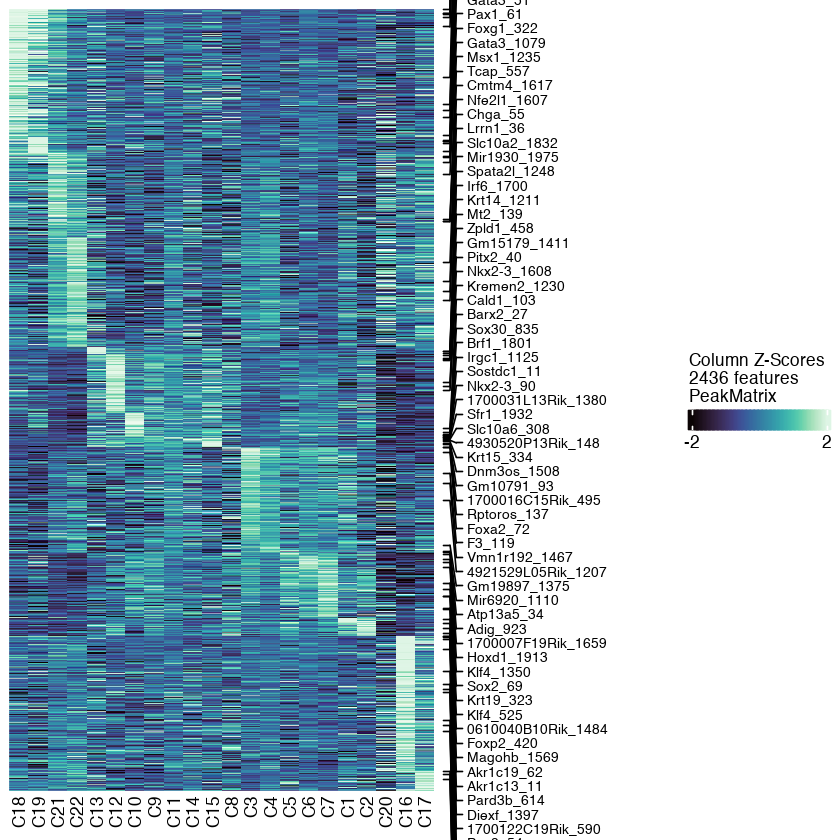

In [82]:
p

In [83]:
plotPDF(p, name = "Fig3a_differentially_accessible_promoter_peaks_logfc_0.5_pval_0.01.pdf", width = 8, height =20, addDOC = F, ArchRProj = projFoxn1ko)

Plotting ComplexHeatmap!



- for boxplot

In [ ]:
heatmapGS_promoter <- plotMarkerHeatmap(
  seMarker = marker_subset_promoter, cutOff = "FDR <= 0.01 & Log2FC >= 0.5",
  # cutOff = "FDR==FDR", #TRUE i.e. use all genes
# labelRows = FALSE,
  labelMarkers = labelMarkers_promoter,returnMatrix=TRUE,scaleRows = FALSE,
  
  limits = c(-2000, 2000)
  #transpose = TRUE,
  #clusterCols=F,
  # binaryClusterRows = F
  #pal = viridis::magma(30)
)


heatmapGS_distal <- plotMarkerHeatmap(
  seMarker = marker_subset_distal, cutOff = "FDR <= 0.01 & Log2FC >= 0.5",
  # cutOff = "FDR==FDR", #TRUE i.e. use all genes
# labelRows = FALSE,
  labelMarkers = labelMarkers_distal,returnMatrix=TRUE,scaleRows = FALSE,
  
  limits = c(-20000, 20000)
  #transpose = TRUE,
  #clusterCols=F,
  # binaryClusterRows = F
  #pal = viridis::magma(30)
)


In [263]:
tpi = function(row_value){
    num_tis = length(row_value)
    tpi_op = sum(1 - row_value / max(row_value))/(num_tis - 1)
    tpi_op
}

prom_spec = apply(heatmapGS_promoter, 1, tpi)

In [264]:
tpi = function(row_value){
    num_tis = length(row_value)
    tpi_op = sum(1 - row_value / max(row_value))/(num_tis - 1)
    tpi_op
}

dist_spec = apply(heatmapGS_distal, 1, tpi)

In [265]:
dist_spec = as.vector(dist_spec)
prom_spec = as.vector(prom_spec)

In [449]:
res <- wilcox.test(prom_spec, dist_spec)

In [450]:
res


	Wilcoxon rank sum test with continuity correction

data:  prom_spec and dist_spec
W = 10060815, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [266]:
to_plot = data.frame(prom_spec)

In [267]:
colnames(to_plot) = 'tissue_specificity'

In [268]:
to_plot['Peak_Type'] = 'Promoter'

In [269]:
to_plot_dist = data.frame(dist_spec)
colnames(to_plot_dist) = 'tissue_specificity'
to_plot_dist['Peak_Type'] = 'Distal'

In [309]:
to_plot_dist[which(is.na(sort(to_plot_dist$tissue_specificity)))]

Warning message in rbind(parts$upper, ellip_v, parts$lower, deparse.level = 0L):
“number of columns of result is not a multiple of vector length (arg 2)”


1    
2    
3    
4    
5    
6    
7    
8    
9    
10   
11   
12   
13   
14   
15   
16   
17   
18   
19   
20   
21   
22   
23   
24   
25   
26   
27   
28   
29   
30   
⋮    
27266
27267
27268
27269
27270
27271
27272
27273
27274
27275
27276
27277
27278
27279
27280
27281
27282
27283
27284
27285
27286
27287
27288
27289
27290
27291
27292
27293
27294
27295

In [270]:
to_plot = rbind(to_plot,to_plot_dist)

In [441]:
plot_pdf = ggplot(to_plot, aes(Peak_Type, tissue_specificity,fill=Peak_Type)) +
 stat_boxplot(geom ='errorbar', width = 0.6)  +  scale_fill_manual(values=c("gray30", "gray57"))  + geom_boxplot()  + theme_classic() + theme(text = element_text(size=10)) +
xlab("Peak Type") + ylab("Cluster Specificity Index")
    

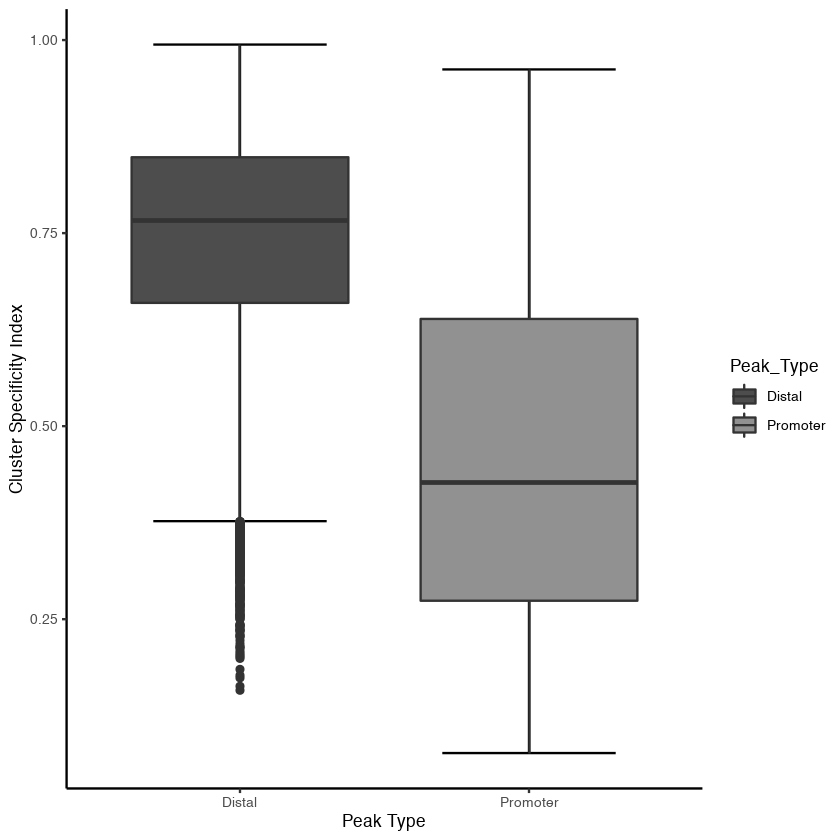

In [442]:
plot_pdf

In [443]:
plotPDF(plot = plot_pdf, 
    name = "Fig3b.pdf", 
    ArchRProj = projFoxn1ko, 
    addDOC = FALSE, width = 10, height = 5)


Plotting Ggplot!

